# Imports

In [ ]:
!mkdir trained_models
import numpy as np
from kora.drive import upload_public
from PIL import Image
import cv2
import matplotlib as plt
import torch
import os
import shutil
from random import random, randint, sample, shuffle

import numpy as np
import torch
import torch.nn as nn
from collections import deque
from torch.cuda import is_available
from google.colab import drive
from google.colab.patches import cv2_imshow
from google.colab import files

mkdir: cannot create directory ‘trained_models’: File exists


# Videos

In [ ]:
from IPython.display import HTML
from base64 import b64encode

def show_video():
    mp4 = open('project.mp4', "rb").read()
    data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
    return HTML("""
<video width=400 controls>
    <source src="%s" type="video/mp4">
</video>
""" % data_url)

# Board Creation / Environment


In [ ]:
"""
Creator of the tetris board:
Viet Nguyen <nhviet1009@gmail.com>
"""
plt.style.use("ggplot")


class Tetris:
    piece_colors = [
        (0, 0, 0),
        (255, 255, 0),
        (147, 88, 254),
        (54, 175, 144),
        (255, 0, 0),
        (0, 255, 255),
        (254, 151, 32),
        (0, 0, 255)
    ]

    pieces = [
        [[1, 1],
         [1, 1]],

        [[0, 2, 0],
         [2, 2, 2]],

        [[0, 3, 3],
         [3, 3, 0]],

        [[4, 4, 0],
         [0, 4, 4]],

        [[5, 5, 5, 5]],

        [[0, 0, 6],
         [6, 6, 6]],

        [[7, 0, 0],
         [7, 7, 7]]
    ]

    def __init__(self, height=20, width=10, block_size=20):
        self.height = height
        self.width = width
        self.block_size = block_size
        self.extra_board = np.ones((self.height * self.block_size, self.width * int(self.block_size / 2), 3),
                                   dtype=np.uint8) * np.array([204, 204, 255], dtype=np.uint8)
        self.text_color = (200, 20, 220)
        self.reset()

    def reset(self):
        self.board = [[0] * self.width for _ in range(self.height)]
        self.score = 0
        self.tetrominoes = 0
        self.cleared_lines = 0
        self.bag = list(range(len(self.pieces)))
        shuffle(self.bag)
        self.ind = self.bag.pop()
        self.piece = [row[:] for row in self.pieces[self.ind]]
        self.current_pos = {"x": self.width // 2 - len(self.piece[0]) // 2, "y": 0}
        self.gameover = False
        return self.get_state_properties(self.board)

    def rotate(self, piece):
        num_rows_orig = num_cols_new = len(piece)
        num_rows_new = len(piece[0])
        rotated_array = []

        for i in range(num_rows_new):
            new_row = [0] * num_cols_new
            for j in range(num_cols_new):
                new_row[j] = piece[(num_rows_orig - 1) - j][i]
            rotated_array.append(new_row)
        return rotated_array

    def get_state_properties(self, board):
        lines_cleared, board = self.check_cleared_rows(board)
        holes = self.get_holes(board)
        bumpiness, height = self.get_bumpiness_and_height(board)

        return torch.FloatTensor([lines_cleared, holes, bumpiness, height])

    def get_holes(self, board):
        num_holes = 0
        for col in zip(*board):
            row = 0
            while row < self.height and col[row] == 0:
                row += 1
            num_holes += len([x for x in col[row + 1:] if x == 0])
        return num_holes

    def get_bumpiness_and_height(self, board):
        board = np.array(board)
        mask = board != 0
        invert_heights = np.where(mask.any(axis=0), np.argmax(mask, axis=0), self.height)
        heights = self.height - invert_heights
        total_height = np.sum(heights)
        currs = heights[:-1]
        nexts = heights[1:]
        diffs = np.abs(currs - nexts)
        total_bumpiness = np.sum(diffs)
        return total_bumpiness, total_height

    def get_next_states(self):
        states = {}
        piece_id = self.ind
        curr_piece = [row[:] for row in self.piece]
        if piece_id == 0:  # O piece
            num_rotations = 1
        elif piece_id == 2 or piece_id == 3 or piece_id == 4:
            num_rotations = 2
        else:
            num_rotations = 4

        for i in range(num_rotations):
            valid_xs = self.width - len(curr_piece[0])
            for x in range(valid_xs + 1):
                piece = [row[:] for row in curr_piece]
                pos = {"x": x, "y": 0}
                while not self.check_collision(piece, pos):
                    pos["y"] += 1
                self.truncate(piece, pos)
                board = self.store(piece, pos)
                states[(x, i)] = self.get_state_properties(board)
            curr_piece = self.rotate(curr_piece)
        return states

    def get_current_board_state(self):
        board = [x[:] for x in self.board]
        for y in range(len(self.piece)):
            for x in range(len(self.piece[y])):
                board[y + self.current_pos["y"]][x + self.current_pos["x"]] = self.piece[y][x]
        return board

    def new_piece(self):
        if not len(self.bag):
            self.bag = list(range(len(self.pieces)))
            shuffle(self.bag)
        self.ind = self.bag.pop()
        self.piece = [row[:] for row in self.pieces[self.ind]]
        self.current_pos = {"x": self.width // 2 - len(self.piece[0]) // 2,
                            "y": 0
                            }
        if self.check_collision(self.piece, self.current_pos):
            self.gameover = True

    def check_collision(self, piece, pos):
        future_y = pos["y"] + 1
        for y in range(len(piece)):
            for x in range(len(piece[y])):
                if future_y + y > self.height - 1 or self.board[future_y + y][pos["x"] + x] and piece[y][x]:
                    return True
        return False

    def truncate(self, piece, pos):
        gameover = False
        last_collision_row = -1
        for y in range(len(piece)):
            for x in range(len(piece[y])):
                if self.board[pos["y"] + y][pos["x"] + x] and piece[y][x]:
                    if y > last_collision_row:
                        last_collision_row = y

        if pos["y"] - (len(piece) - last_collision_row) < 0 and last_collision_row > -1:
            while last_collision_row >= 0 and len(piece) > 1:
                gameover = True
                last_collision_row = -1
                del piece[0]
                for y in range(len(piece)):
                    for x in range(len(piece[y])):
                        if self.board[pos["y"] + y][pos["x"] + x] and piece[y][x] and y > last_collision_row:
                            last_collision_row = y
        return gameover

    def store(self, piece, pos):
        board = [x[:] for x in self.board]
        for y in range(len(piece)):
            for x in range(len(piece[y])):
                if piece[y][x] and not board[y + pos["y"]][x + pos["x"]]:
                    board[y + pos["y"]][x + pos["x"]] = piece[y][x]
        return board

    def check_cleared_rows(self, board):
        to_delete = []
        for i, row in enumerate(board[::-1]):
            if 0 not in row:
                to_delete.append(len(board) - 1 - i)
        if len(to_delete) > 0:
            board = self.remove_row(board, to_delete)
        return len(to_delete), board

    def remove_row(self, board, indices):
        for i in indices[::-1]:
            del board[i]
            board = [[0 for _ in range(self.width)]] + board
        return board

    def step(self, action, render=True, video=None):
        x, num_rotations = action
        self.current_pos = {"x": x, "y": 0}
        for _ in range(num_rotations):
            self.piece = self.rotate(self.piece)

        while not self.check_collision(self.piece, self.current_pos):
            self.current_pos["y"] += 1
            if render:
                self.render(video)

        overflow = self.truncate(self.piece, self.current_pos)
        if overflow:
            self.gameover = True

        self.board = self.store(self.piece, self.current_pos)

        lines_cleared, self.board = self.check_cleared_rows(self.board)
        score = 1 + (lines_cleared ** 2) * self.width
        self.score += score
        self.tetrominoes += 1
        self.cleared_lines += lines_cleared
        if not self.gameover:
            self.new_piece()
        if self.gameover:
            self.score -= 2

        return score, self.gameover

    def render(self, video=None):
        if not self.gameover:
            img = [self.piece_colors[p] for row in self.get_current_board_state() for p in row]
        else:
            img = [self.piece_colors[p] for row in self.board for p in row]
        img = np.array(img).reshape((self.height, self.width, 3)).astype(np.uint8)
        img = img[..., ::-1]
        img = Image.fromarray(img, "RGB")

        img = img.resize((self.width * self.block_size, self.height * self.block_size))
        img = np.array(img)
        img[[i * self.block_size for i in range(self.height)], :, :] = 0
        img[:, [i * self.block_size for i in range(self.width)], :] = 0

        img = np.concatenate((img, self.extra_board), axis=1)


        cv2.putText(img, "Score:", (self.width * self.block_size + int(self.block_size / 2), self.block_size),
                    fontFace=cv2.FONT_HERSHEY_DUPLEX, fontScale=1.0, color=self.text_color)
        cv2.putText(img, str(self.score),
                    (self.width * self.block_size + int(self.block_size / 2), 2 * self.block_size),
                    fontFace=cv2.FONT_HERSHEY_DUPLEX, fontScale=1.0, color=self.text_color)

        cv2.putText(img, "Pieces:", (self.width * self.block_size + int(self.block_size / 2), 4 * self.block_size),
                    fontFace=cv2.FONT_HERSHEY_DUPLEX, fontScale=1.0, color=self.text_color)
        cv2.putText(img, str(self.tetrominoes),
                    (self.width * self.block_size + int(self.block_size / 2), 5 * self.block_size),
                    fontFace=cv2.FONT_HERSHEY_DUPLEX, fontScale=1.0, color=self.text_color)

        cv2.putText(img, "Lines:", (self.width * self.block_size + int(self.block_size / 2), 7 * self.block_size),
                    fontFace=cv2.FONT_HERSHEY_DUPLEX, fontScale=1.0, color=self.text_color)
        cv2.putText(img, str(self.cleared_lines),
                    (self.width * self.block_size + int(self.block_size / 2), 8 * self.block_size),
                    fontFace=cv2.FONT_HERSHEY_DUPLEX, fontScale=1.0, color=self.text_color)

        
        video.append(img)


# Neural Network

In [ ]:
import torch.nn as nn

class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()

        self.l1 = nn.Sequential(nn.Linear(4, 64), nn.ReLU(inplace=True))
        self.l2 = nn.Sequential(nn.Linear(64, 64), nn.ReLU(inplace=True))
        self.l3 = nn.Sequential(nn.Linear(64, 1))

        self.apply_weights()

    def apply_weights(self):
        for n in self.modules():
            if isinstance(n, nn.Linear):
                nn.init.xavier_uniform_(n.weight)
                nn.init.constant_(n.bias, 0)

    def forward(self, x):
        x = self.l1(x)
        x = self.l2(x)
        x = self.l3(x)

        return x

# Agent

In [ ]:
class Agent(object):
    def __init__(self, environment, learR):
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.model = NeuralNetwork(environment.observation_space.shape[0], environment.action_space.n).to(self.device)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=learR)
        self.criterion = nn.MSELoss()

    def act(self, state, env):
        # move the state to a Torch Tensor
        state = torch.from_numpy(state).unsqueeze(0).to(self.device)

        # find the probabilities of taking each action
        probs = self.model(state).cpu()

        # creates a categorical distribution parameterized by probs 
        m = torch.distributions.Categorical(probs)

        # choose an action from the probability distribution
        action = m.sample()

        # return that action, and the chance we chose that action
        return action.item(), m.log_prob(action)


# Run

In [ ]:
def run(videoPath):
    if torch.cuda.is_available():
        model = torch.load("{}/tetris".format("trained_models"))
    else:
        model = torch.load("{}/tetris".format("trained_models"), map_location=lambda storage, loc: storage)
    model.eval()
    env = Tetris()
    env.reset()
    if torch.cuda.is_available():
        model.cuda()

    while True:
        next_steps = env.get_next_states()
        next_actions, next_states = zip(*next_steps.items())
        next_states = torch.stack(next_states)
        if torch.cuda.is_available():
            next_states = next_states.cuda()
        predictions = model(next_states)[:, 0]
        index = torch.argmax(predictions).item()
        action = next_actions[index]
        _, done = env.step(action, render=True, video = videoPath)

        if done:
            break

# Train

In [ ]:
def trainFirst(leR, linesCleared, score, epochs, to1000):
  if torch.cuda.is_available():
      torch.cuda.manual_seed(123)
  else:
      torch.manual_seed(123)

  env = Tetris()

  model = NeuralNetwork()
  optimizer = torch.optim.Adam(model.parameters(), lr=leR)
  criterion = nn.MSELoss()

  state = env.reset()
  if torch.cuda.is_available():
      model.cuda()
      state = state.cuda()

  lineCount = 0
  replay_memory = deque(maxlen=30000)
  ep = 0
  while ep < epochs:
    next_steps = env.get_next_states()
    e = 1e-3 + (max(2000 - ep, 0) * (1 - 1e-3) / 2000)
    rand = random()
    random_action = rand <= e
    next_actions, next_states = zip(*next_steps.items())
    next_states = torch.stack(next_states)
    if torch.cuda.is_available():
      next_states = next_states.cuda()
    model.eval()
    with torch.no_grad():
      pred = model(next_states)[:,0]
    model.train()
    if random_action:
      index = randint(0, len(next_steps) - 1)
    else:
      index = torch.argmax(pred).item()

    next_state = next_states[index, :]
    action = next_actions[index]
    reward, done = env.step(action, False)

    if torch.cuda.is_available():
      next_state = next_state.cuda()
    replay_memory.append([state, reward, next_state, done])
    if done:
        final_score = env.score
        final_tetrominoes = env.tetrominoes
        final_cleared_lines = env.cleared_lines
        state = env.reset()
        if torch.cuda.is_available():
            state = state.cuda()
    else:
        state = next_state
        continue
    if len(replay_memory) < 30000 / 10:
        continue
    ep += 1
    batch = sample(replay_memory, min(len(replay_memory), 512))
    state_batch, reward_batch, next_state_batch, done_batch = zip(*batch)
    state_batch = torch.stack(tuple(state for state in state_batch))
    reward_batch = torch.from_numpy(np.array(reward_batch, dtype=np.float32)[:, None])
    next_state_batch = torch.stack(tuple(state for state in next_state_batch))

    if torch.cuda.is_available():
        state_batch = state_batch.cuda()
        reward_batch = reward_batch.cuda()
        next_state_batch = next_state_batch.cuda()

    q_values = model(state_batch)
    model.eval()
    with torch.no_grad():
        next_prediction_batch = model(next_state_batch)
    model.train()

    y_batch = torch.cat(
        tuple(reward if done else reward + .99 * prediction for reward, done, prediction in
              zip(reward_batch, done_batch, next_prediction_batch)))[:, None]

    optimizer.zero_grad()
    loss = criterion(q_values, y_batch)
    loss.backward()
    optimizer.step()

    linesCleared.append(final_cleared_lines)
    score.append(final_score)

    if ep > 0 and ep % 100 == 0:
      torch.save(model, "{}/tetris_{}".format("trained_models", ep))
      print("Epoch {}".format(ep))

    if final_cleared_lines >= 1000 and to1000:
      return

    if final_cleared_lines > 50000:
      torch.save(model, "{}/tetris_{}".format("trained_models", ep))
      return

  torch.save(model, "{}/tetris".format("trained_models"))

In [ ]:
linesCleared = []
numEpochs = [i for i in range(1, 3001)]
score = []
trainFirst(1e-2, linesCleared, score, 3000, True)

linesCleared2 = []
score2 = []
trainFirst(5e-3, linesCleared2, score2, 3000, True)

linesCleared3 = []
score3 = []
trainFirst(1e-3, linesCleared3, score3, 3000, True)

linesCleared4 = []
score4 = []
trainFirst(5e-4, linesCleared4, score4, 3000, True)

linesCleared5 = []
score5 = []
trainFirst(1e-4, linesCleared5, score5, 3000, True)

linesCleared6 = []
score6 = []
trainFirst(5e-5, linesCleared6, score6, 3000, True)

linesCleared7 = []
score7 = []
trainFirst(1e-5, linesCleared7, score7, 3000, True)

#v = trainFirst(True)

Epoch 100
Epoch 200
Epoch 300
Epoch 400
Epoch 500
Epoch 600
Epoch 700
Epoch 800
Epoch 900
Epoch 1000
Epoch 1100
Epoch 1200
Epoch 1300
Epoch 1400
Epoch 1500
Epoch 1600
Epoch 1700
Epoch 1800
Epoch 1900
Epoch 2000
Epoch 2100
Epoch 2200
Epoch 2300
Epoch 2400
Epoch 2500
Epoch 2600
Epoch 2700
Epoch 100
Epoch 200
Epoch 300
Epoch 400
Epoch 500
Epoch 600
Epoch 700
Epoch 800
Epoch 900
Epoch 1000
Epoch 1100
Epoch 1200
Epoch 1300
Epoch 1400
Epoch 1500
Epoch 1600
Epoch 1700
Epoch 1800
Epoch 1900
Epoch 2000
Epoch 2100
Epoch 100
Epoch 200
Epoch 300
Epoch 400
Epoch 500
Epoch 600
Epoch 700
Epoch 800
Epoch 900
Epoch 1000
Epoch 1100
Epoch 1200
Epoch 1300
Epoch 1400
Epoch 1500
Epoch 1600
Epoch 1700
Epoch 1800
Epoch 1900
Epoch 100
Epoch 200
Epoch 300
Epoch 400
Epoch 500
Epoch 600
Epoch 700
Epoch 800
Epoch 900
Epoch 1000
Epoch 1100
Epoch 1200
Epoch 1300
Epoch 1400
Epoch 1500
Epoch 1600
Epoch 1700
Epoch 1800
Epoch 1900
Epoch 2000
Epoch 100
Epoch 200
Epoch 300
Epoch 400
Epoch 500
Epoch 600
Epoch 700
Epoch 800

# TestingLearningRate Graphs

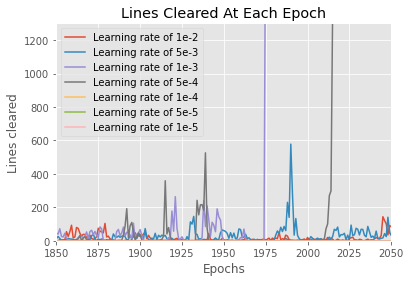

In [ ]:
while(len(linesCleared) < 3000):
  linesCleared.append(linesCleared[len(linesCleared) - 1])

while(len(linesCleared2) < 3000):
  linesCleared2.append(linesCleared2[len(linesCleared2) - 1])

while(len(linesCleared3) < 3000):
  linesCleared3.append(linesCleared3[len(linesCleared3) - 1])

while(len(linesCleared4) < 3000):
  linesCleared4.append(linesCleared4[len(linesCleared4) - 1])

while(len(linesCleared5) < 3000):
  linesCleared5.append(linesCleared5[len(linesCleared5) - 1])

while(len(linesCleared6) < 3000):
  linesCleared6.append(linesCleared6[len(linesCleared6) - 1])

while(len(linesCleared7) < 3000):
  linesCleared7.append(linesCleared7[len(linesCleared7) - 1])

while(len(linesCleared7) < 3000):
  linesCleared7.append(linesCleared7[len(linesCleared7) - 1])

plt.pyplot.plot(numEpochs, linesCleared, label = "Learning rate of 1e-2")
plt.pyplot.plot(numEpochs, linesCleared2, label = "Learning rate of 5e-3")
plt.pyplot.plot(numEpochs, linesCleared3, label = "Learning rate of 1e-3")
plt.pyplot.plot(numEpochs, linesCleared4, label = "Learning rate of 5e-4")
plt.pyplot.plot(numEpochs, linesCleared5, label = "Learning rate of 1e-4")
plt.pyplot.plot(numEpochs, linesCleared6, label = "Learning rate of 5e-5")
plt.pyplot.plot(numEpochs, linesCleared7, label = "Learning rate of 1e-5")

plt.pyplot.ylim([0,1300])
plt.pyplot.xlim([1850,2050])
plt.pyplot.xlabel("Epochs")
plt.pyplot.ylabel("Lines cleared")
plt.pyplot.title("Lines Cleared At Each Epoch")
plt.pyplot.legend()
plt.pyplot.show()

# Testing randomness

In [ ]:
linesCleared = []
numEpochs = []
averageEpoch = []
trainFirst(5e-3, linesCleared, score, 3000, True)
averageEpoch.append(len(linesCleared))
trainFirst(5e-3, linesCleared, score, 3000, True)
averageEpoch.append(len(linesCleared))
trainFirst(5e-3, linesCleared, score, 3000, True)
averageEpoch.append(len(linesCleared))
trainFirst(1e-3, linesCleared, score, 3000, True)
averageEpoch.append(len(linesCleared))
trainFirst(1e-3, linesCleared, score, 3000, True)
averageEpoch.append(len(linesCleared))
trainFirst(1e-3, linesCleared, score, 3000, True)
averageEpoch.append(len(linesCleared))
trainFirst(5e-4, linesCleared, score, 3000, True)
averageEpoch.append(len(linesCleared))
trainFirst(5e-4, linesCleared, score, 3000, True)
averageEpoch.append(len(linesCleared))
trainFirst(5e-4, linesCleared, score, 3000, True)
averageEpoch.append(len(linesCleared))

Epoch 100
Epoch 200
Epoch 300
Epoch 400
Epoch 500
Epoch 600
Epoch 700
Epoch 800
Epoch 900
Epoch 1000
Epoch 1100
Epoch 1200
Epoch 1300
Epoch 1400
Epoch 1500
Epoch 1600
Epoch 1700
Epoch 1800
Epoch 1900
Epoch 100
Epoch 200
Epoch 300
Epoch 400
Epoch 500
Epoch 600
Epoch 700
Epoch 800
Epoch 900
Epoch 1000
Epoch 1100
Epoch 1200
Epoch 1300
Epoch 1400
Epoch 1500
Epoch 1600
Epoch 1700
Epoch 1800
Epoch 1900
Epoch 2000
Epoch 100
Epoch 200
Epoch 300
Epoch 400
Epoch 500
Epoch 600
Epoch 700
Epoch 800
Epoch 900
Epoch 1000
Epoch 1100
Epoch 1200
Epoch 1300
Epoch 1400
Epoch 1500
Epoch 1600
Epoch 1700
Epoch 1800
Epoch 1900
Epoch 2000
Epoch 100
Epoch 200
Epoch 300
Epoch 400
Epoch 500
Epoch 600
Epoch 700
Epoch 800
Epoch 900
Epoch 1000
Epoch 1100
Epoch 1200
Epoch 1300
Epoch 1400
Epoch 1500
Epoch 1600
Epoch 1700
Epoch 1800
Epoch 1900
Epoch 2000
Epoch 2100
Epoch 2200
Epoch 100
Epoch 200
Epoch 300
Epoch 400
Epoch 500
Epoch 600
Epoch 700
Epoch 800
Epoch 900
Epoch 1000
Epoch 1100
Epoch 1200
Epoch 1300
Epoch 1400


# Testing randomness Graphs

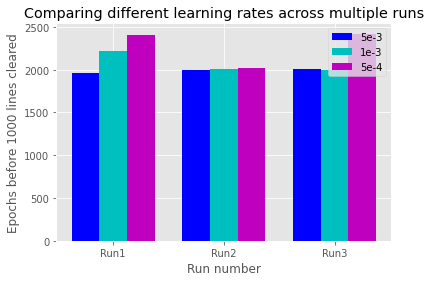

1990.0
2077.3333333333335
2282.6666666666665


In [ ]:
newHelp = []
for i in range(1, len(averageEpoch)):
  newHelp.append(averageEpoch[len(averageEpoch) - i] - averageEpoch[len(averageEpoch) - i - 1])
newHelp.append(averageEpoch[0])
data = [[newHelp[8], newHelp[7], newHelp[6]], [newHelp[5], newHelp[4], newHelp[3]], [newHelp[2], newHelp[1], newHelp[0]]]
br1 = np.arange(len(data[0]))
br2 = [i + 0.25 for i in br1]
br3 = [i + 0.25 for i in br2]
plt.pyplot.bar(br1, data[0], color = 'b', width = 0.25, label = "5e-3")
plt.pyplot.bar(br2, data[1], color = 'c', width = 0.25, label = "1e-3")
plt.pyplot.bar(br3, data[2], color = 'm', width = 0.25, label = "5e-4")
plt.pyplot.xlabel('Run number')
plt.pyplot.ylabel('Epochs before 1000 lines cleared')
plt.pyplot.title('Comparing different learning rates across multiple runs')
plt.pyplot.xticks([i + 0.25 for i in range(len(data[0]))],['Run1', 'Run2', 'Run3'])
plt.pyplot.legend()
plt.pyplot.show()

print((newHelp[8] + newHelp[7] + newHelp[6]) / 3)
print((newHelp[5] + newHelp[4] + newHelp[3]) / 3)
print((newHelp[2] + newHelp[1] + newHelp[0]) / 3)

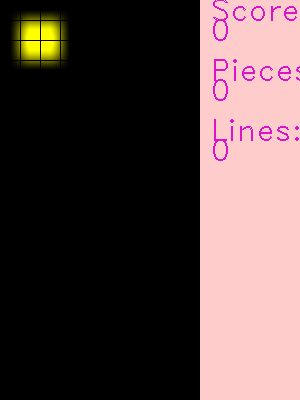

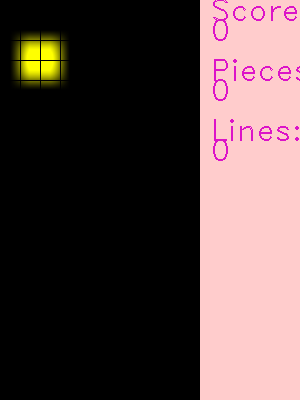

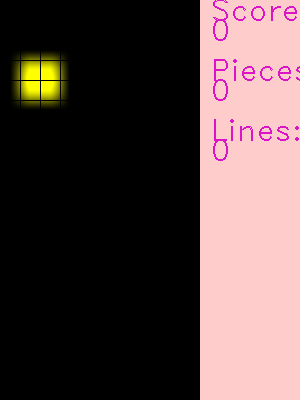

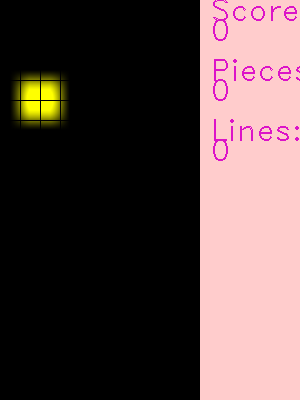

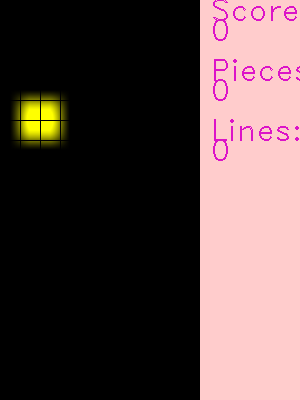

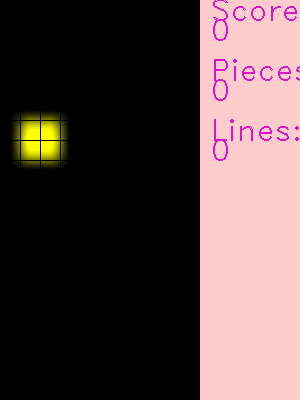

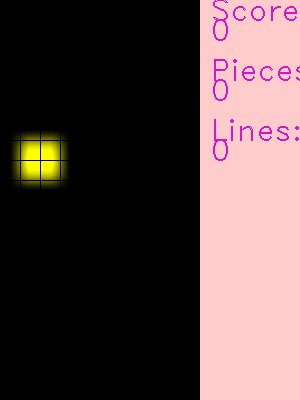

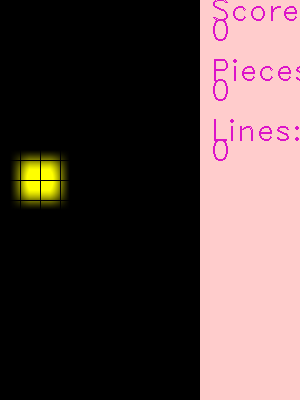

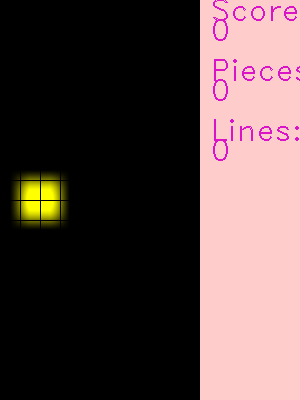

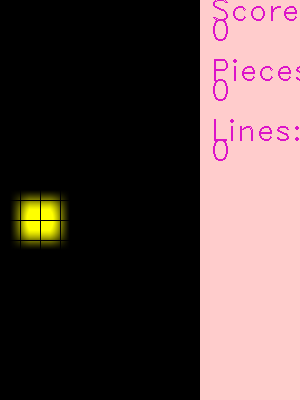

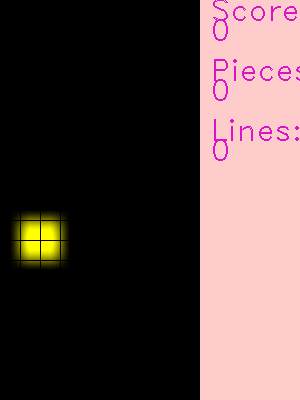

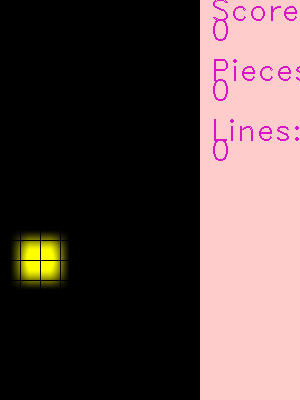

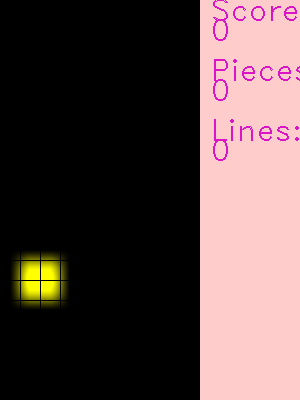

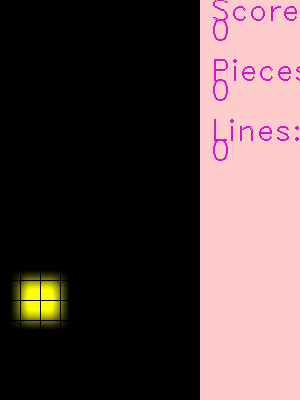

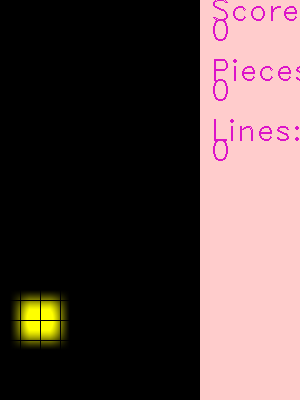

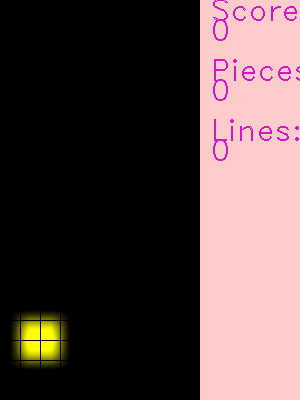

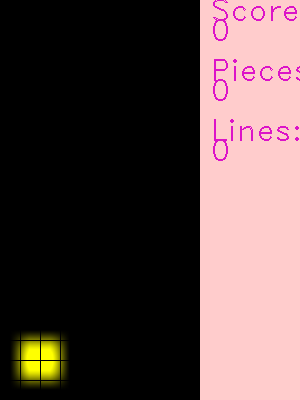

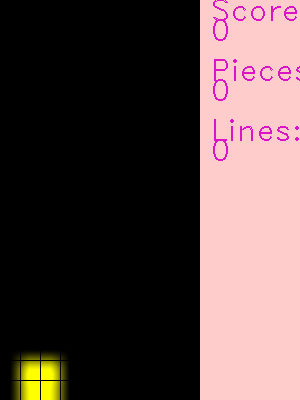

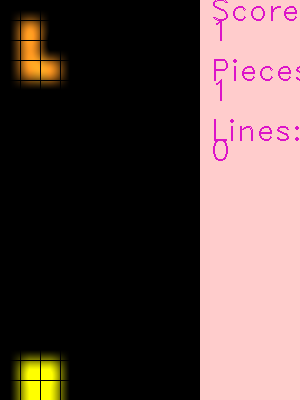

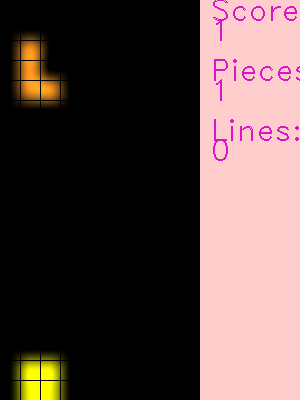

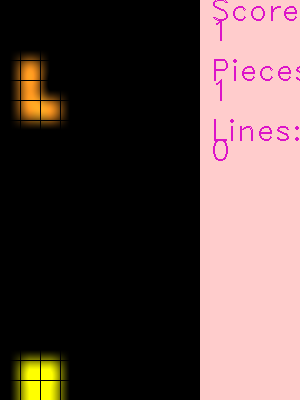

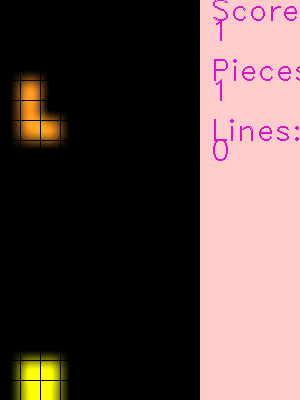

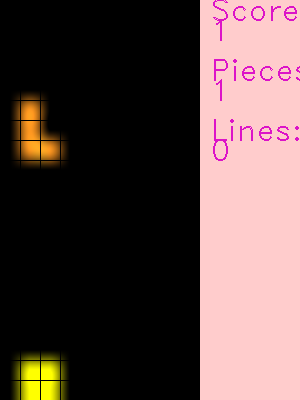

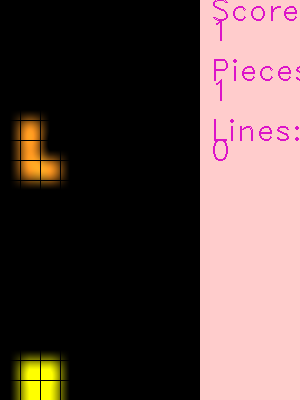

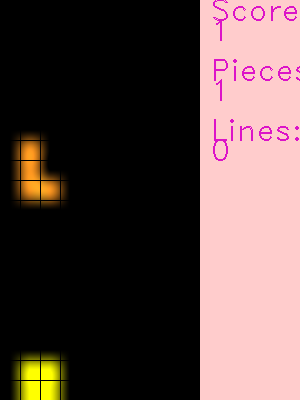

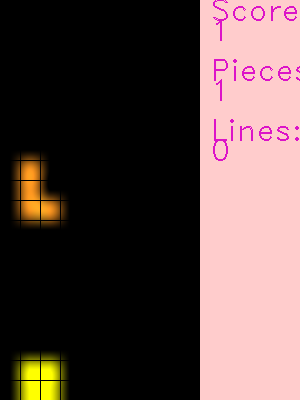

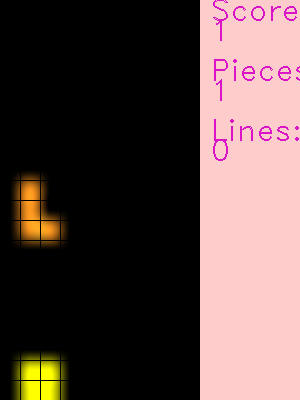

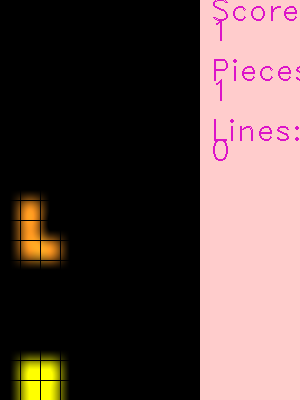

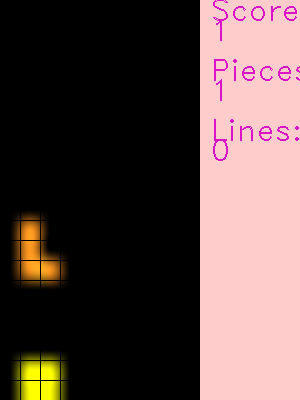

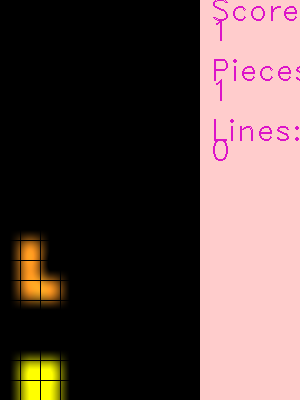

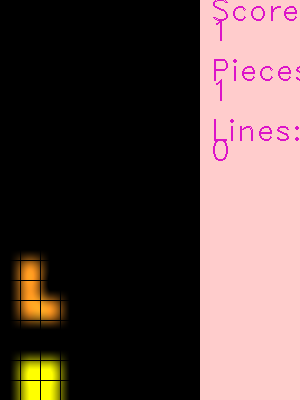

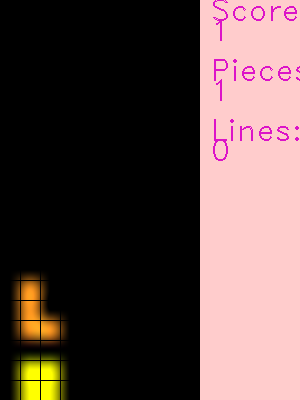

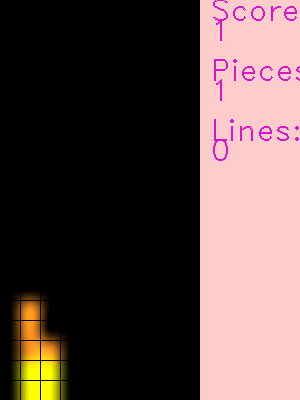

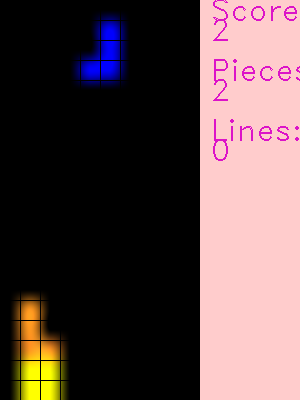

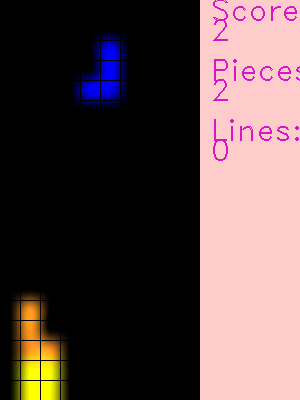

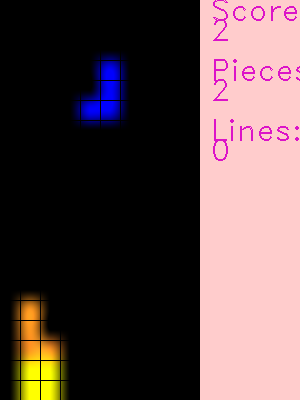

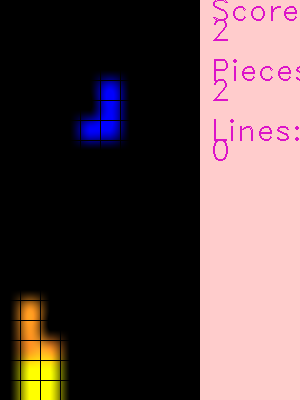

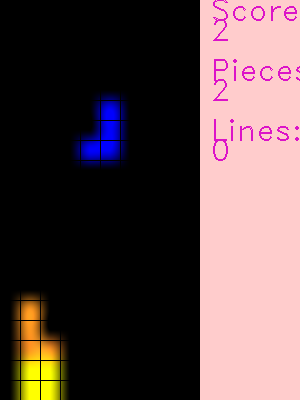

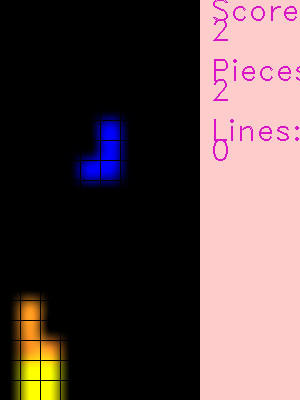

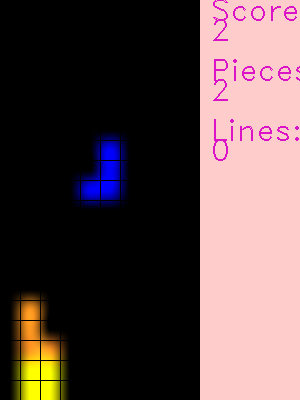

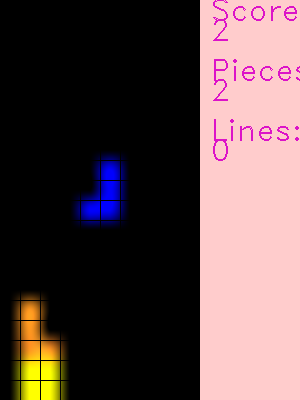

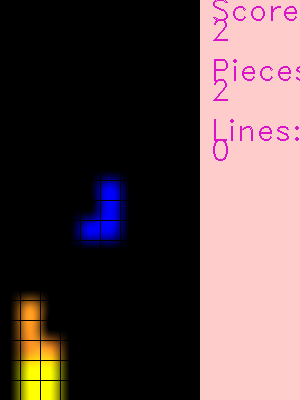

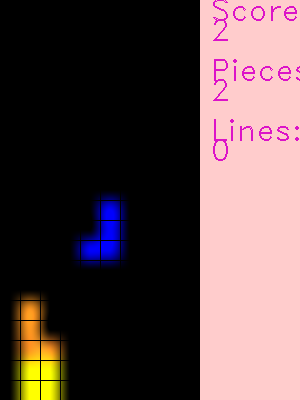

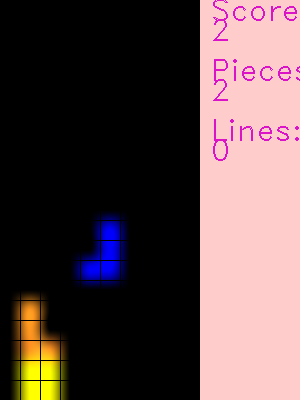

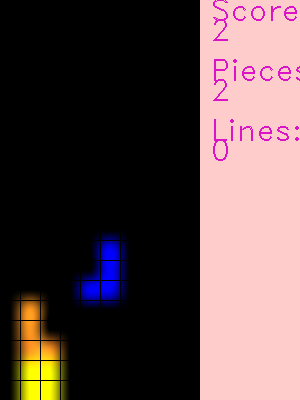

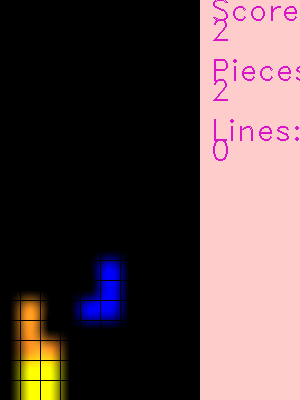

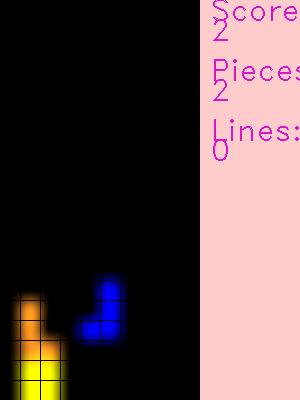

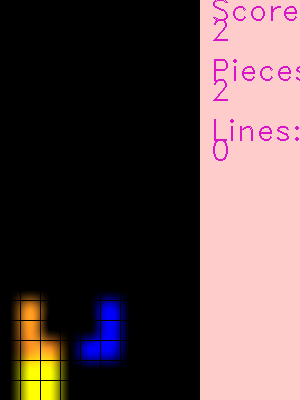

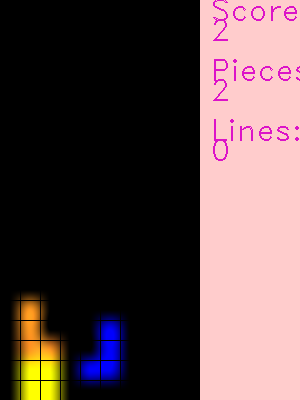

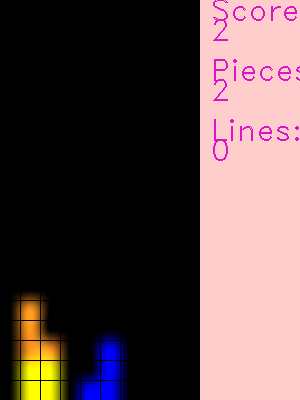

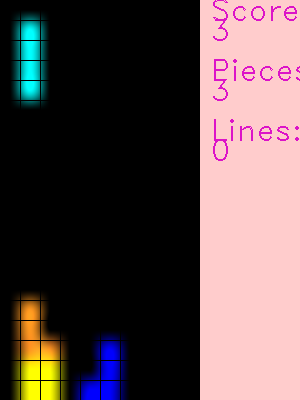

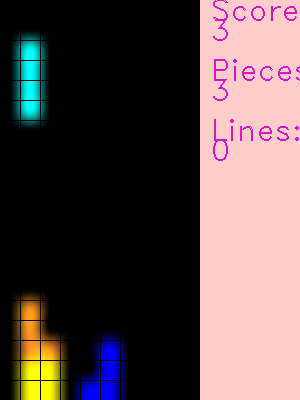

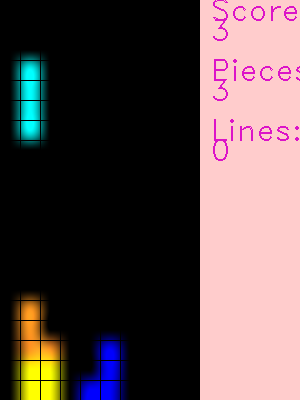

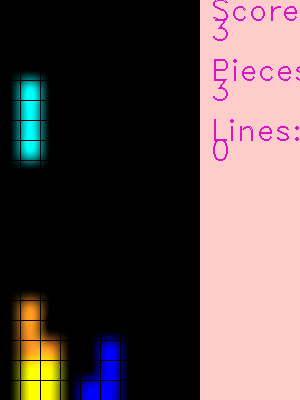

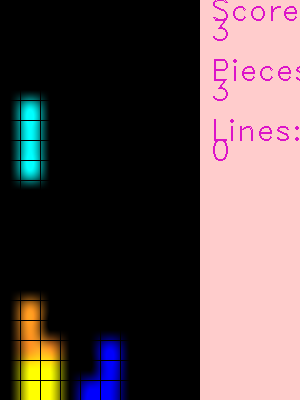

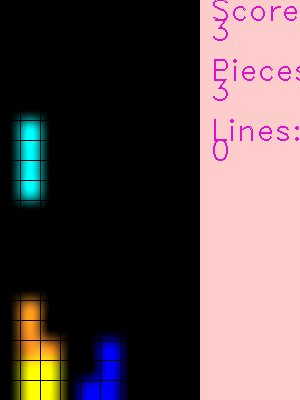

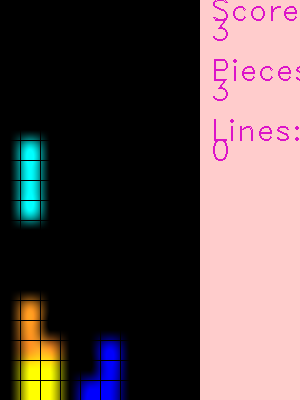

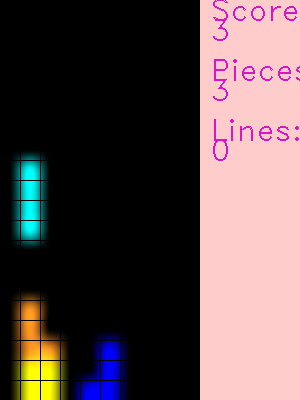

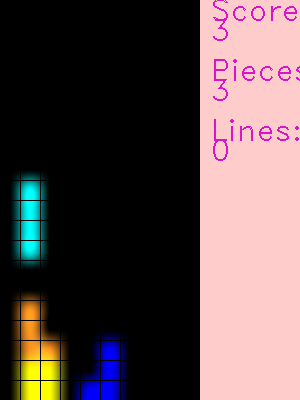

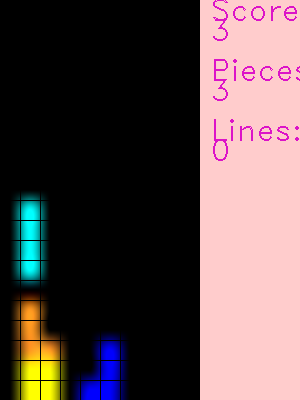

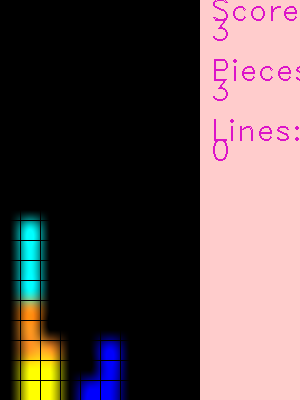

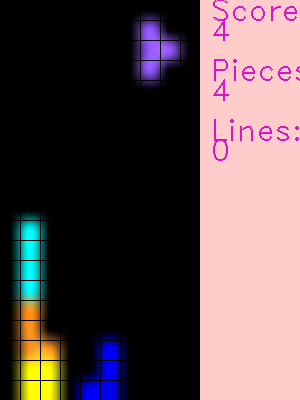

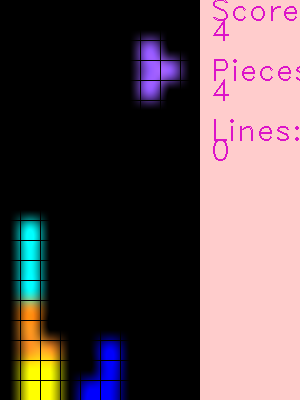

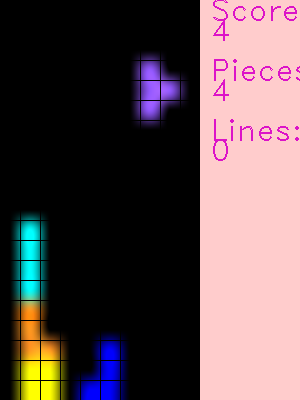

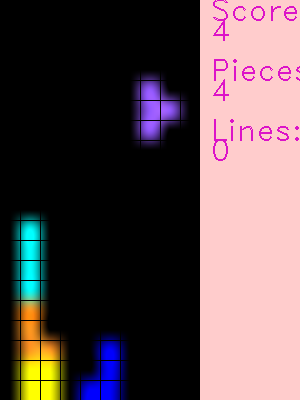

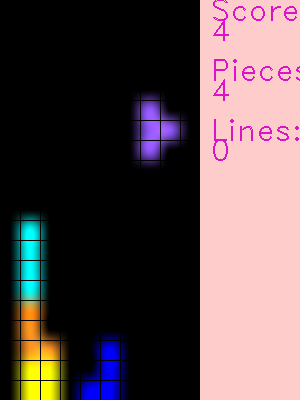

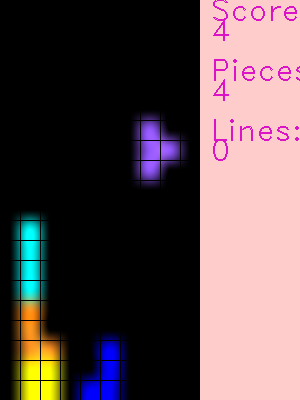

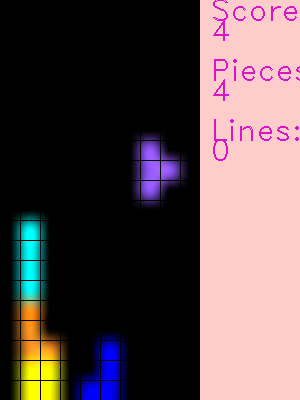

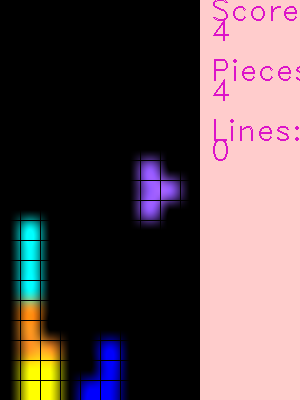

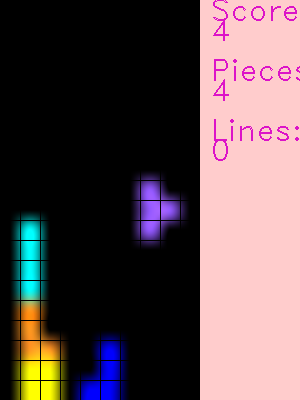

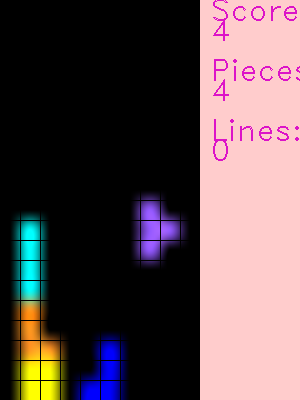

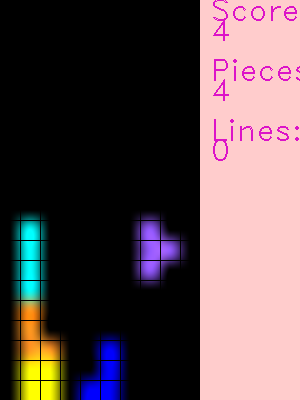

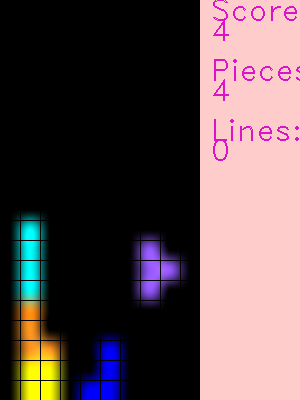

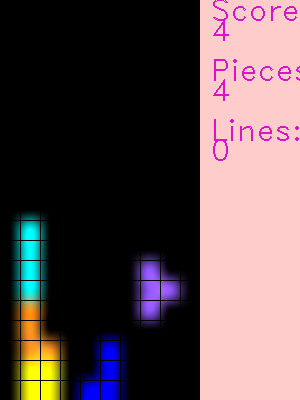

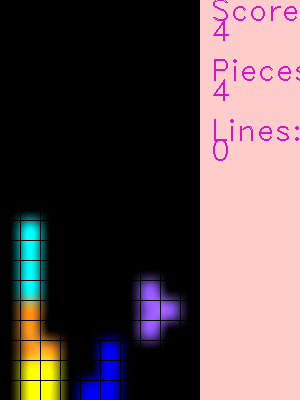

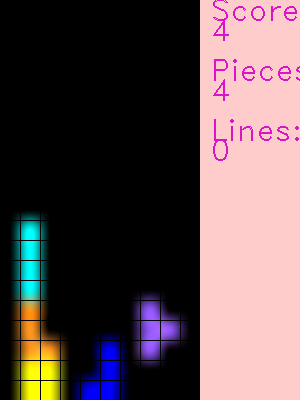

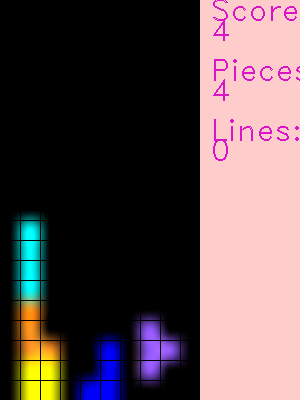

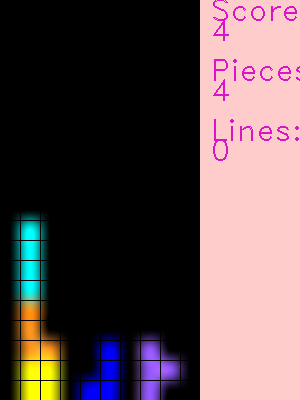

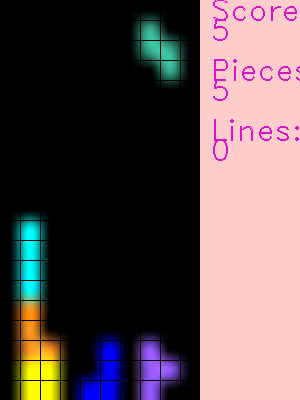

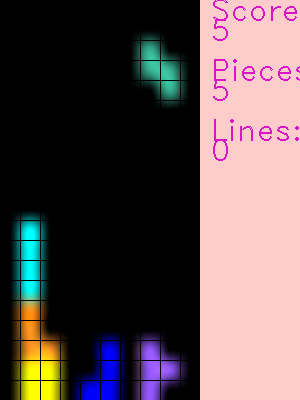

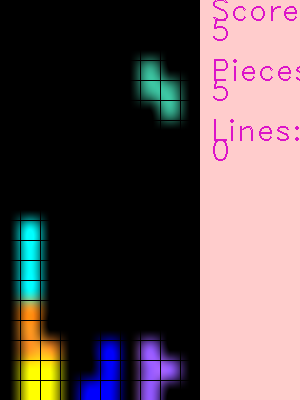

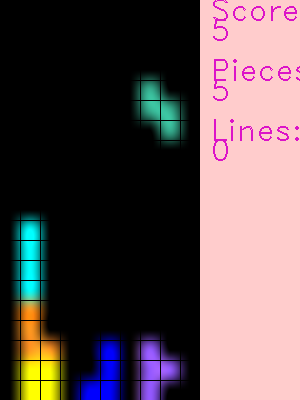

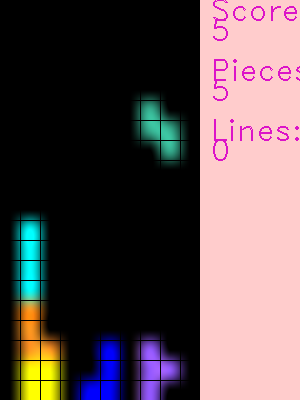

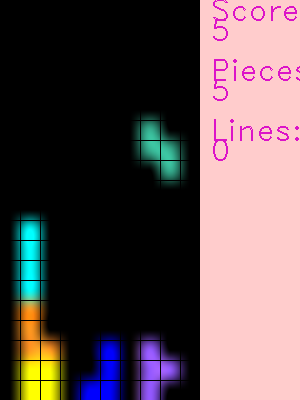

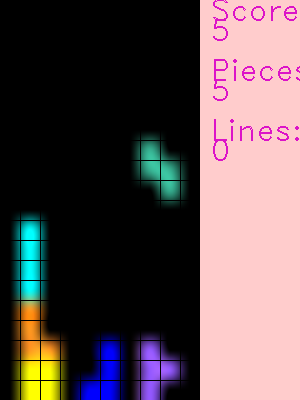

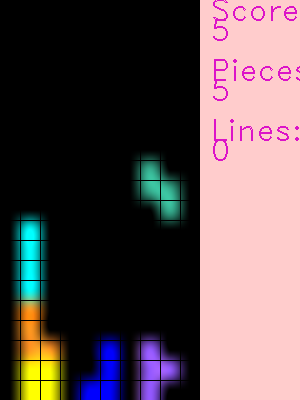

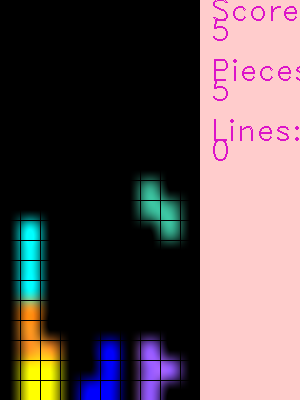

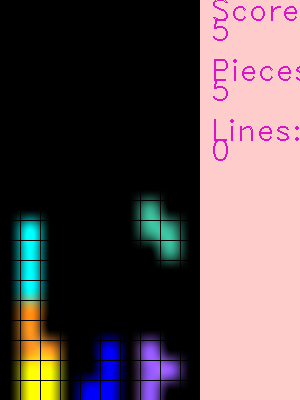

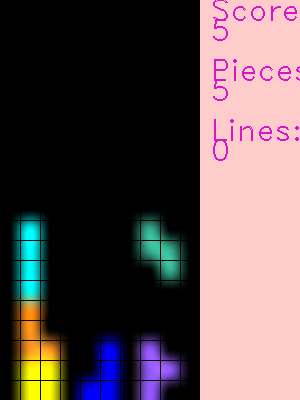

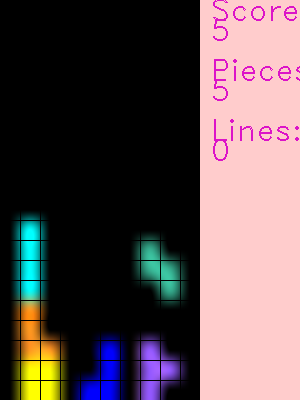

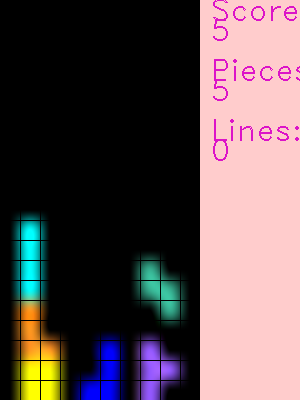

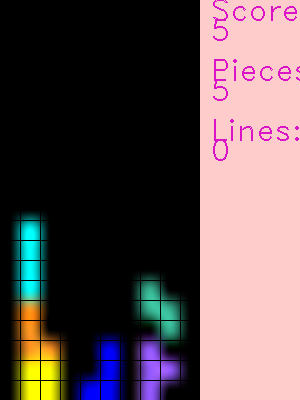

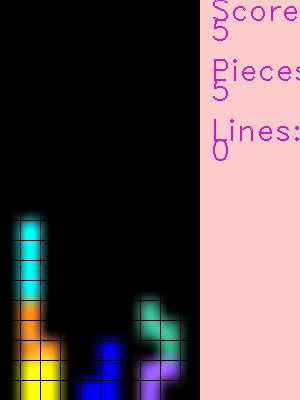

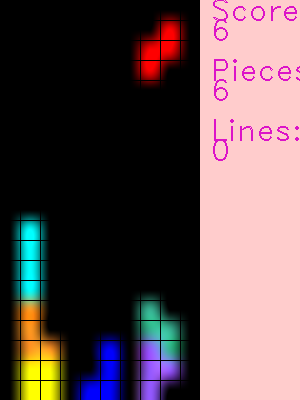

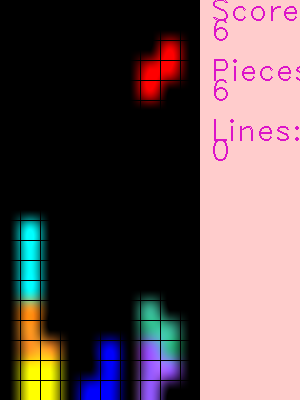

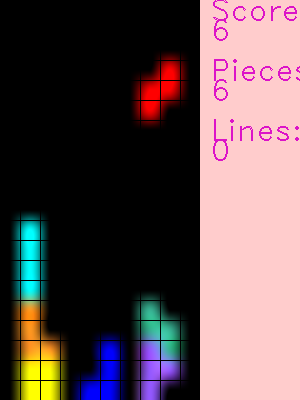

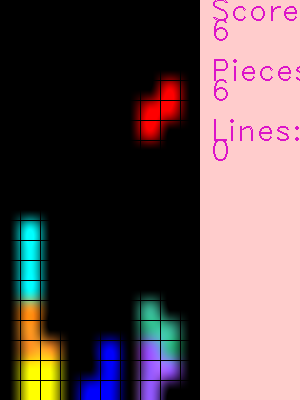

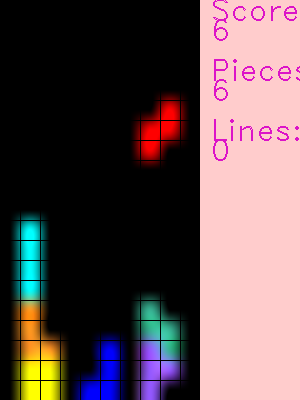

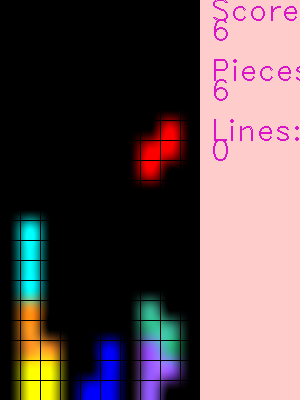

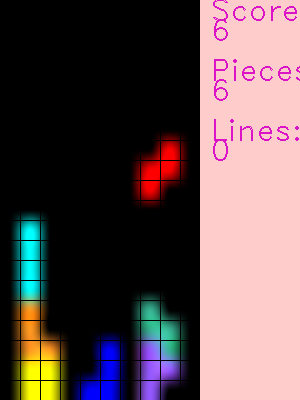

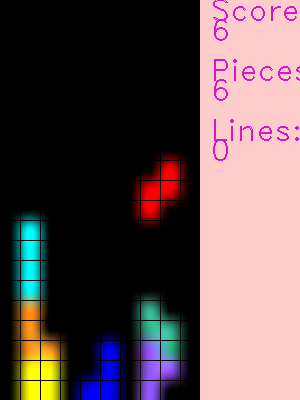

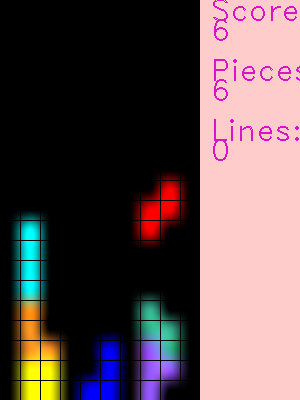

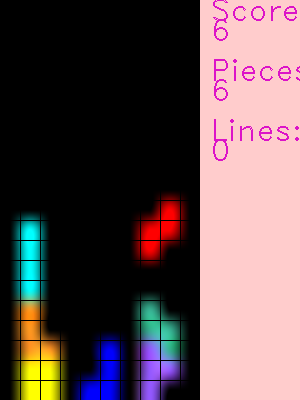

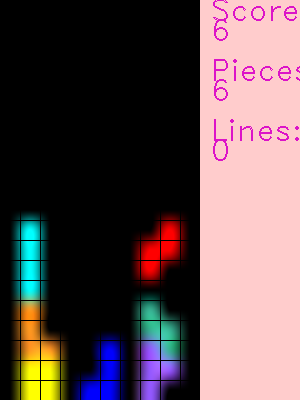

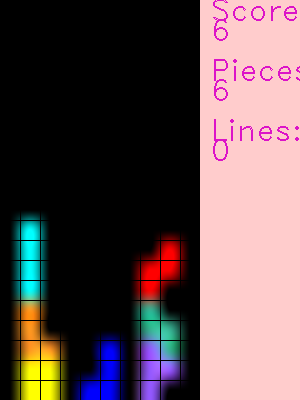

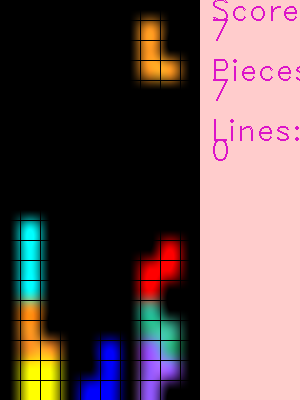

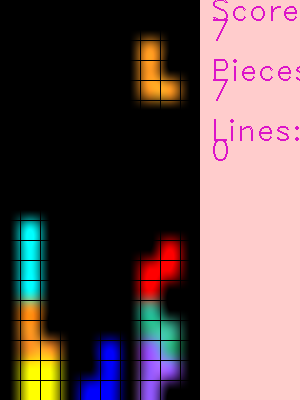

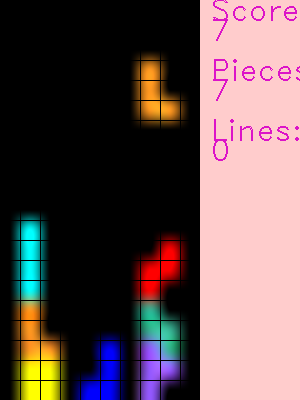

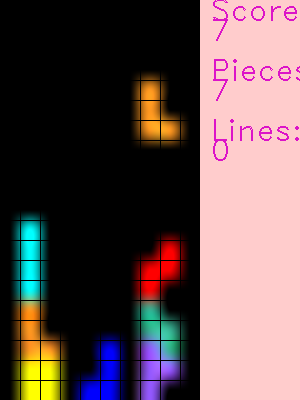

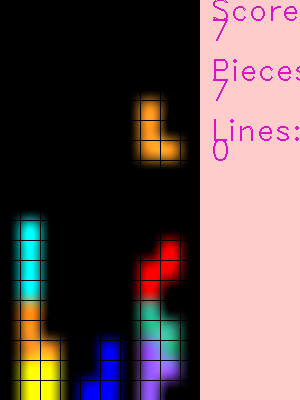

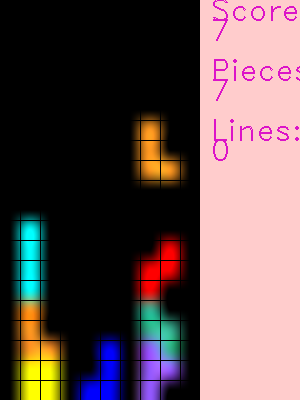

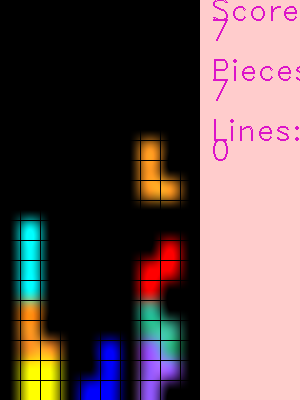

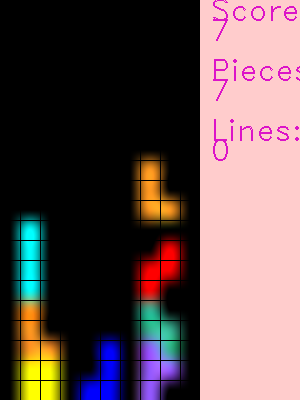

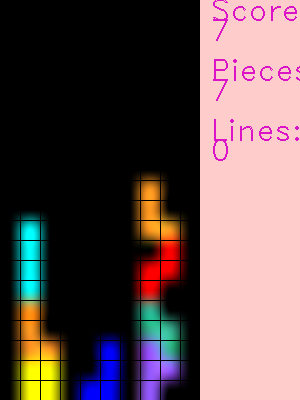

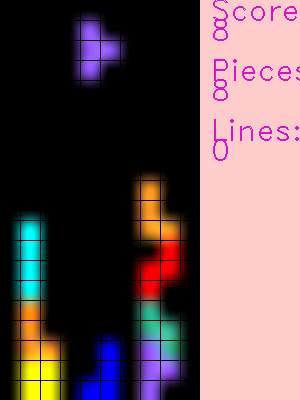

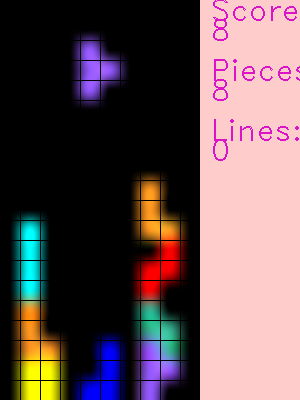

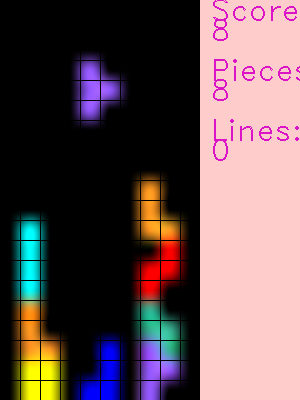

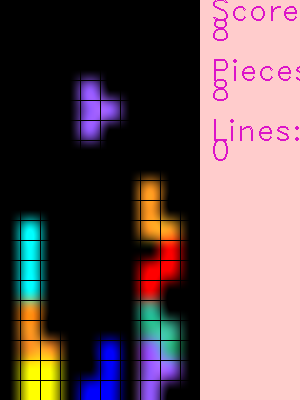

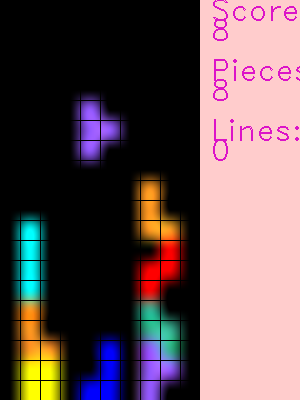

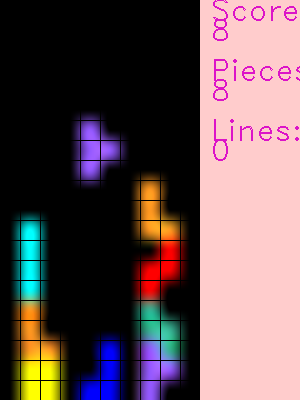

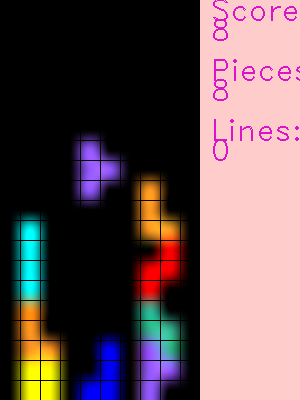

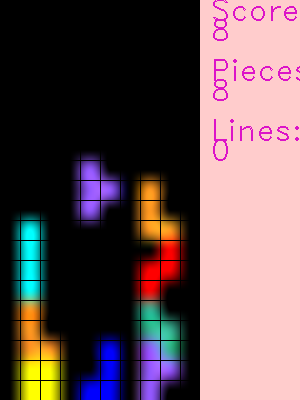

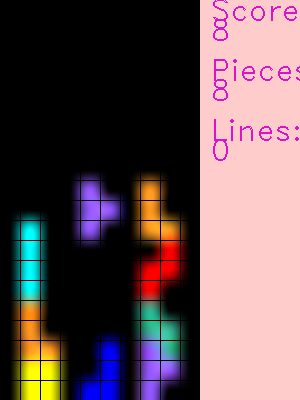

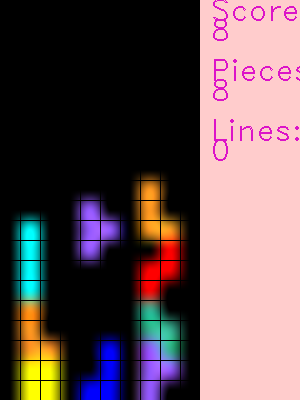

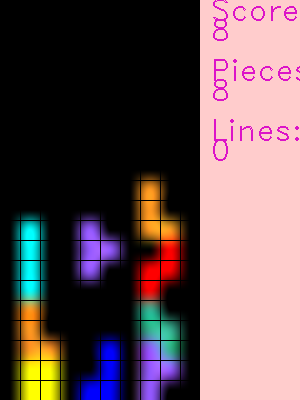

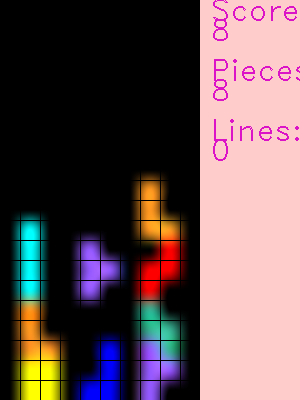

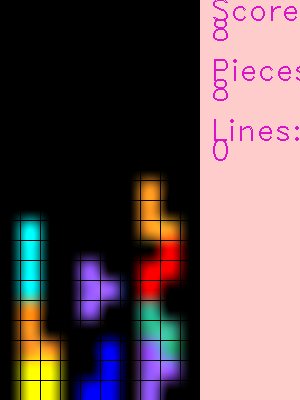

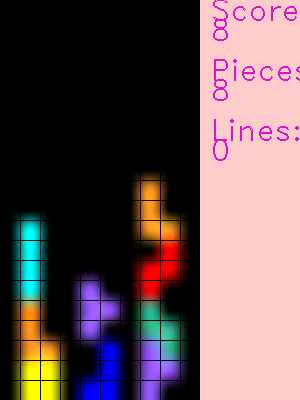

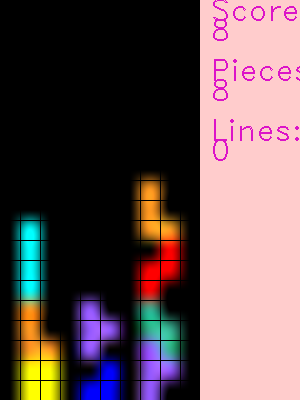

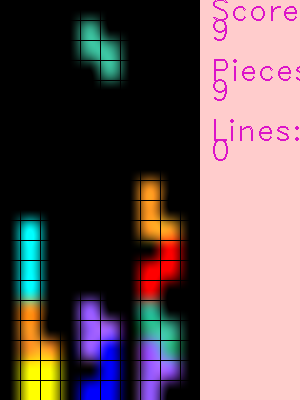

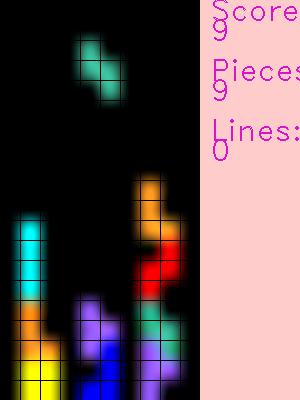

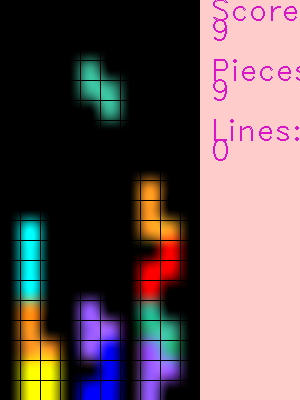

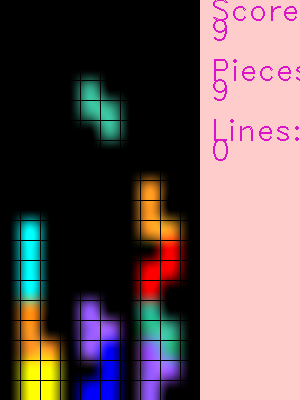

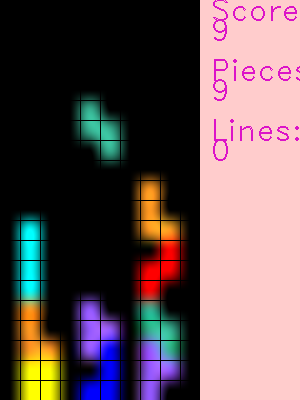

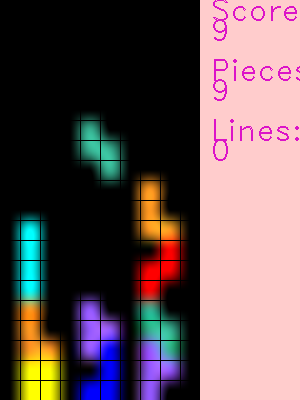

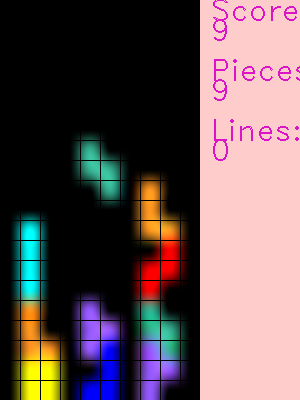

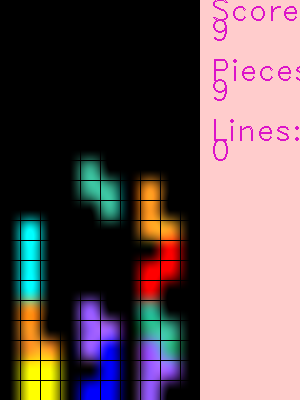

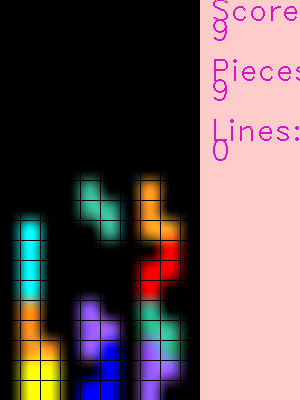

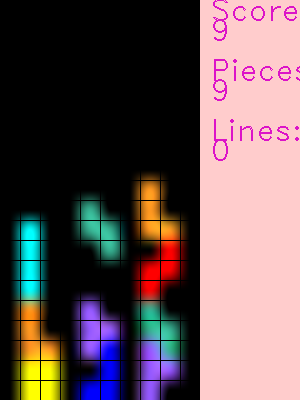

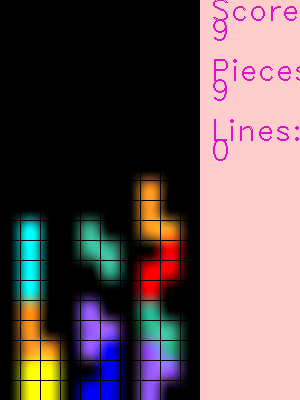

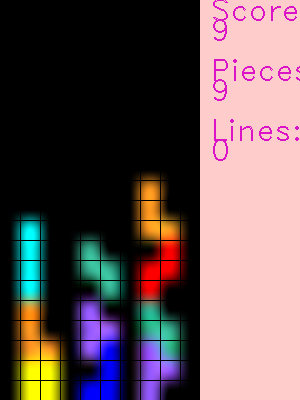

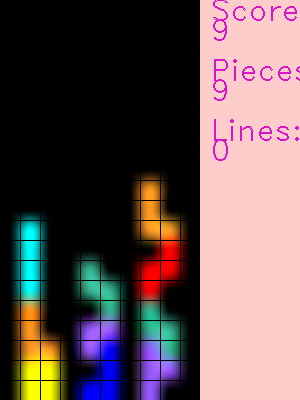

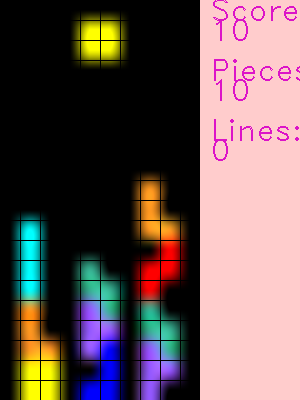

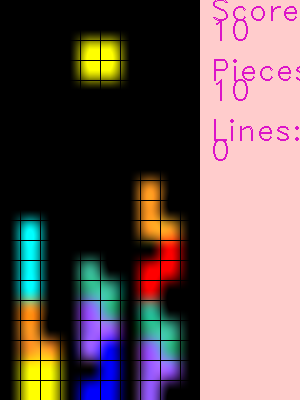

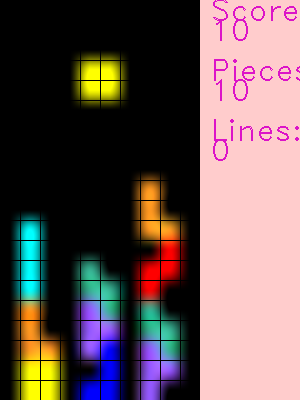

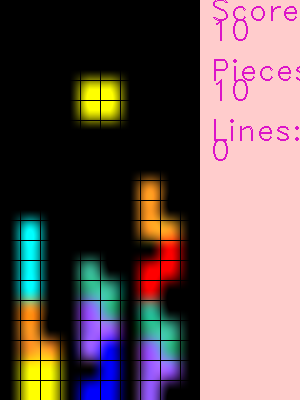

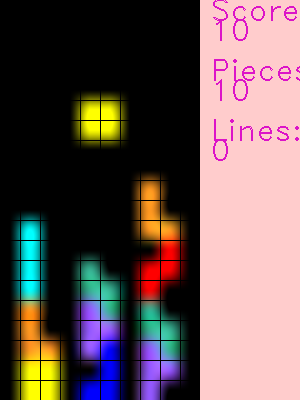

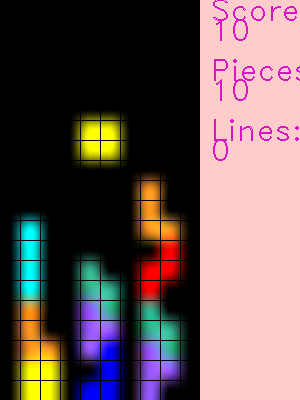

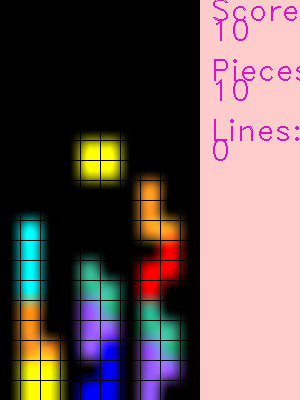

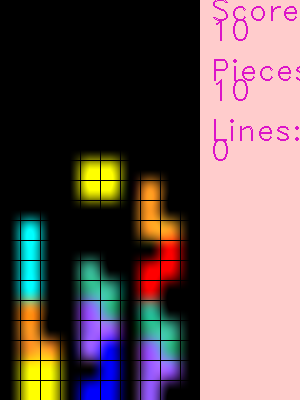

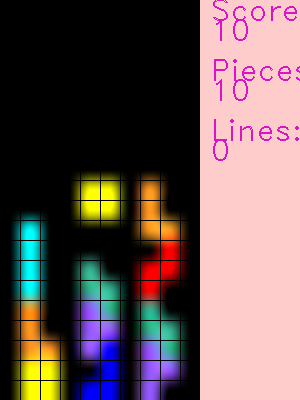

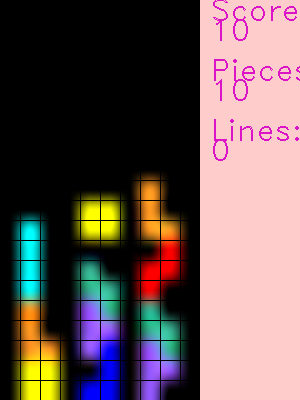

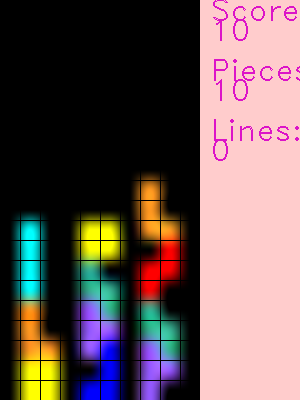

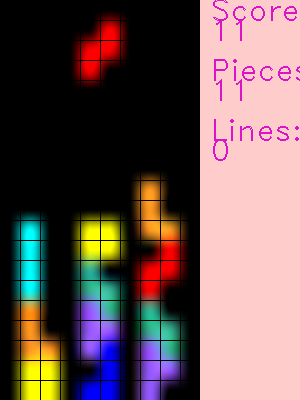

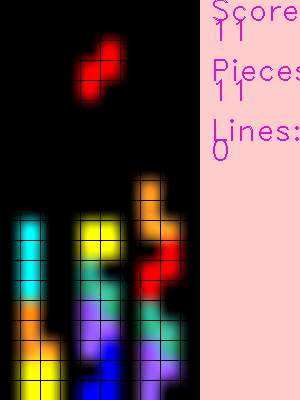

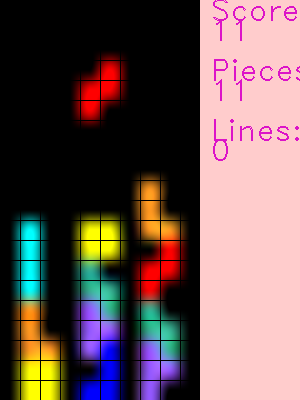

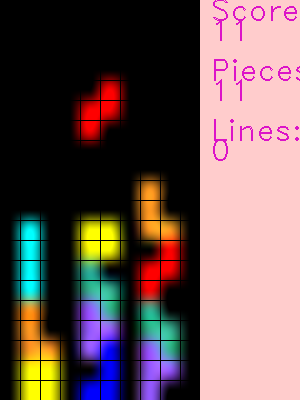

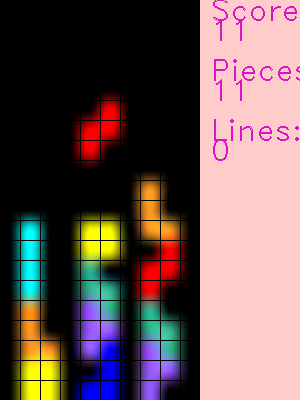

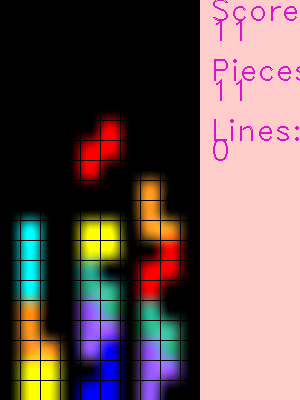

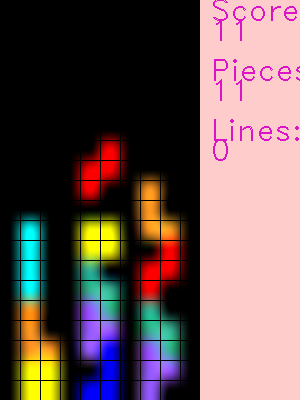

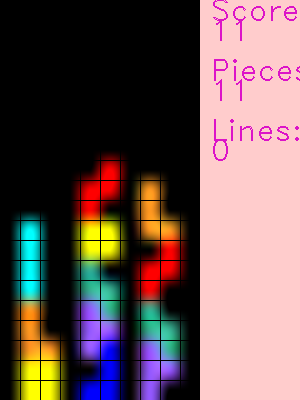

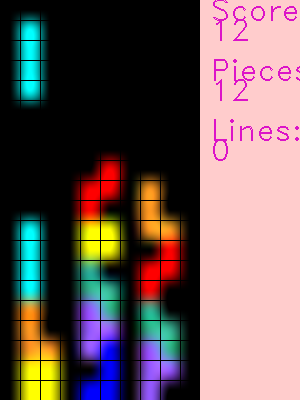

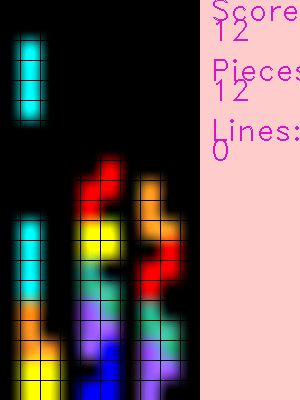

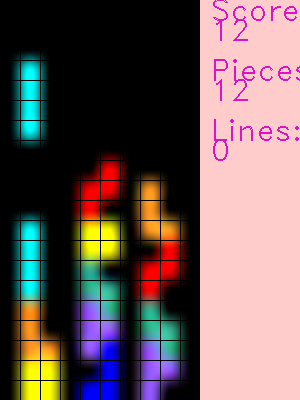

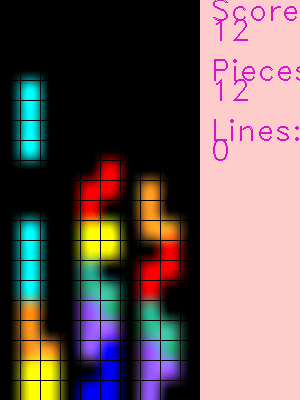

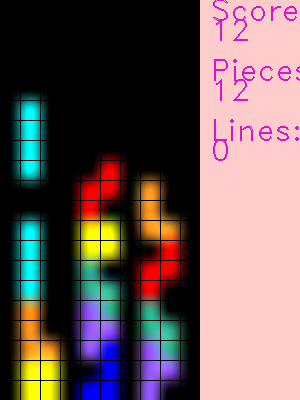

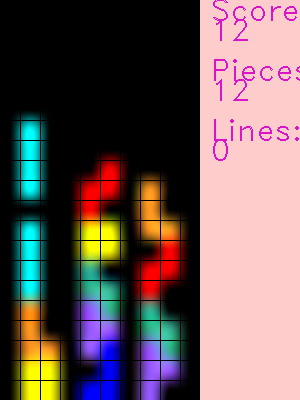

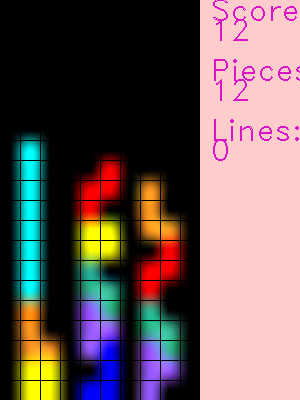

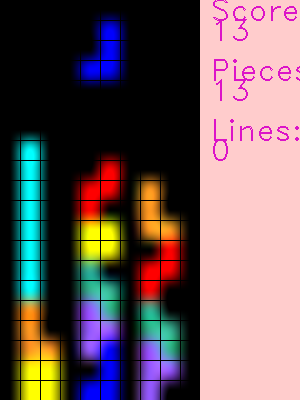

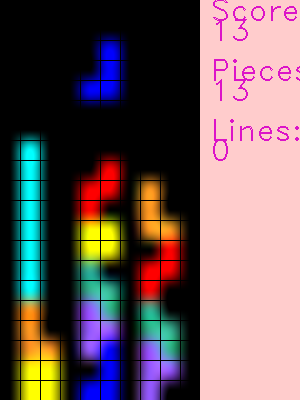

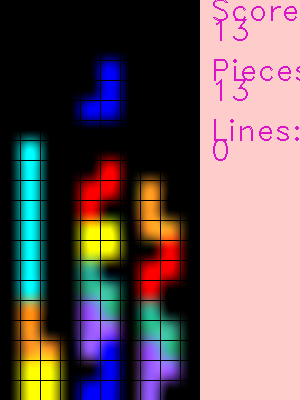

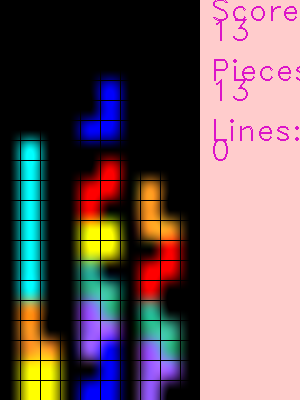

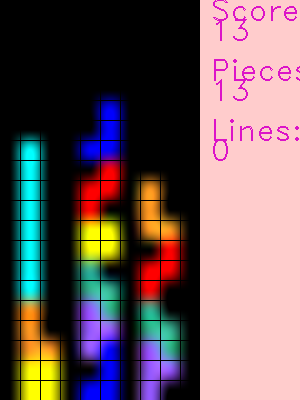

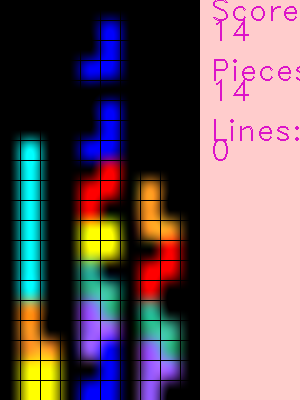

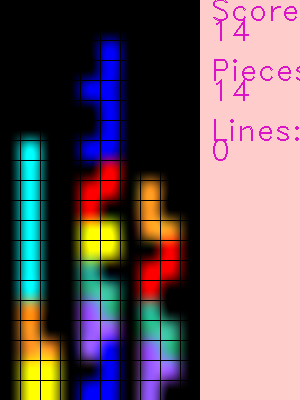

In [ ]:
finImg = []
run(finImg)

# Download video

In [ ]:
### This downloads a video, it does not show it.
trainFirst(3e-3, linesCleared, numEpochs, 2200, False)
video = []
run(video)

f1 = video[0]
height, width, layers = f1.shape
size = (width, height)

out = cv2.VideoWriter('project.mp4', cv2.VideoWriter_fourcc(*'DIVX'), 15, size)

for i in range(len(video)):
  out.write(video[i])
out.release()

files.download("project.mp4")

Epoch 100
Epoch 200
Epoch 300
Epoch 400
Epoch 500
Epoch 600
Epoch 700
Epoch 800
Epoch 900
Epoch 1000
Epoch 1100
Epoch 1200
Epoch 1300
Epoch 1400
Epoch 1500
Epoch 1600
Epoch 1700
Epoch 1800
Epoch 1900
Epoch 2000
Epoch 2100
Epoch 2200


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>